In [1]:
# @title Data retrieval
import os, requests
#download data 
fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [3]:
# @title Install packages (`nilearn`, `nimare`. `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt
import pandas as pd 
from sklearn import datasets
from sklearn import svm
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error , confusion_matrix, accuracy_score

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

     |████████████████████████████████| 9.6 MB 4.5 MB/s 
     |████████████████████████████████| 13.3 MB 5.4 MB/s 
     |████████████████████████████████| 3.2 MB 35.9 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 86 kB 2.7 MB/s 
     |████████████████████████████████| 179 kB 36.3 MB/s 


In [4]:
# @title Data loading
import numpy as np
from pickle import TRUE
alldat = np.load(fname, allow_pickle=True)['dat']

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat1 = alldat[0][0]
dat2 = alldat[0][1]
# get trial number
# print(len(dat1['stim_id']))

#get trial number
# print(alldat.shape)

In [5]:
# function to get subsets of data
def get_sub_dat(alldata, sub_id, exp_id):
  return alldata[sub_id][exp_id]

In [6]:
def dftime_win(dat):
  data = {'t_on': dat['t_on'], 't_off': dat['t_off'], 'stim_id': dat['stim_id']}
  dftime = pd.DataFrame(data)
  return dftime

In [201]:
def dat_frame_t(dat):
  #get dft
  a = dat['V']
  epoch_id=[]
  for i in range(a.shape[1]):
    epoch_id.append(i+1)
  epoch_id_array = np.array(epoch_id)
  df = pd.DataFrame(a, columns=epoch_id)
  dft = df.T
  return dft

In [203]:
# dat = get_sub_dat(alldat, 4, 0)
# datf = dat_frame_t(dat)
# datf

,0,1,2,3,4,5,6,7,8,9,...,390630,390631,390632,390633,390634,390635,390636,390637,390638,390639
1,0.780273,0.155151,0.365723,0.833008,0.396729,0.020538,0.292725,0.256592,-0.304932,0.165527,...,-0.571289,-0.619141,-0.138550,-0.194580,-0.428711,-0.082275,-0.041046,-0.486328,0.198730,0.441895
2,0.606934,0.048584,0.269531,0.738281,0.390869,0.097412,0.373047,0.353516,-0.143555,0.253906,...,-0.442871,-0.495605,-0.118896,-0.274902,-0.568359,-0.311768,-0.319824,-0.734863,-0.077515,0.187378
3,0.850586,0.330078,0.522461,0.926758,0.597168,0.335449,0.605957,0.613770,0.198608,0.581543,...,-0.566895,-0.595703,-0.227905,-0.312256,-0.513184,-0.242310,-0.233643,-0.591797,-0.016449,0.205933
4,2.404297,1.688477,2.046875,2.728516,2.296875,1.952148,2.388672,2.417969,1.792969,2.412109,...,-0.465088,-0.627930,-0.142212,-0.329102,-0.676758,-0.260254,-0.223999,-0.765625,0.121704,0.467285
5,1.822266,1.057617,1.426758,2.125000,1.656250,1.295898,1.753906,1.768555,1.114258,1.756836,...,-0.303955,-0.378662,0.173828,-0.013939,-0.416992,-0.074219,-0.124756,-0.756348,0.127563,0.470459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,-0.028503,-0.320801,-0.173340,0.115723,-0.059296,-0.223755,-0.058319,-0.040192,-0.306641,-0.054260,...,-0.091980,-0.117432,0.134033,0.108154,-0.028214,0.130737,0.133911,-0.115723,0.256592,0.426758
61,-0.464111,-0.966797,-0.808105,-0.422363,-0.710938,-1.004883,-0.842773,-0.901855,-1.330078,-0.964844,...,-0.170288,-0.133057,0.270508,0.235474,0.036591,0.262939,0.265625,-0.097534,0.391357,0.557617
62,-1.179688,-1.570312,-1.424805,-1.104492,-1.311523,-1.490234,-1.305664,-1.323242,-1.655273,-1.357422,...,-0.801758,-0.790039,-0.465332,-0.465820,-0.579102,-0.363281,-0.341553,-0.607422,-0.170654,0.018829
63,-2.835938,-3.330078,-3.179688,-2.806641,-3.068359,-3.296875,-3.072266,-3.046875,-3.369141,-2.974609,...,-0.670410,-0.694336,-0.394775,-0.499756,-0.721191,-0.517090,-0.509277,-0.823242,-0.313232,-0.102783


In [8]:
#generate X for SVM
def slice_chan_dat(dft,dftime,channel_i):
  chan_i = dft.loc[channel_i]
  chan_array = []
  for j in range (0, len(dftime)):
    chan_array.append(chan_i[dftime["t_on"][j]: dftime["t_off"][j]])
  # print(chan_array.shape)
  # ar_chan_i = chan_array.values
  result = np.array([np.array(xi) for xi in chan_array])
  return result

In [9]:
#generate y for SVM
def get_y_val(subdat):
  y = subdat['stim_id']
  return y

In [10]:
#recode all the label of the stimulus id
def label_recode(dataf):
  new_stim_id_array = np.zeros(60)
  for stim_id , i in zip(dataf['stim_id'],range(0,60)) :
    if stim_id == 11 :
      new_stim_id_array[i] = 0
    else :
      new_stim_id_array[i] = 1
    return new_stim_id_array

In [15]:
def get_new_stim_id_array(dat_name, length=60):
  new_stim_id_array = np.zeros(60)
  for stim_id , i in zip(dat2['stim_id'],range(0,60)) :
    if stim_id == 11 :
      new_stim_id_array[i] = 0
    else :
      new_stim_id_array[i] = 1
  return new_stim_id_array

In [214]:
# get data from subject 0, experiment 0
dat = get_sub_dat(alldat, 6, 1)
# dat

In [215]:
datf = dat_frame_t(dat)
dftime = dftime_win(dat)
# get X and y input for the SVM
X1 = slice_chan_dat(datf, dftime, 44)
X2 = slice_chan_dat(datf, dftime, 30)
y_id = get_y_val(dat)
y = get_new_stim_id_array(dat, length=60)
# y = label_recode(dat)
# print(dat)
# X_stack = np.stack((X1, X2), axis=0)

In [62]:
# tests
# print(X1.shape)
# print(y.shape)
# print(y[59]

In the next part, we will feed the transformed data into a Support Vector Machine Model.

In [216]:
x = X1
y = y
# x_t = X1.T
# x_t_downsamp = x_t[::5]
# x_downsamp = x_t_downsamp.T

In [217]:
def down_sample(X, desired_len = 55):
  # transpose matrix
  x_t = X.T
  # slice the matrix
  x_t_downsamp = x_t[::X.shape[1]//desired_len]
  # transpose the matrix back to normal
  x_downsamp = x_t_downsamp.T
  return x_downsamp
# print(x_downsamp.shape)
down_sample(x).shape

(60, 56)

In [218]:
def SVM_ECoG(X, y, down_samp=False, down_samp_len=3000, gam=0.001, C_value=100, test_dat_size=10):
  clf = svm.SVC(gamma=gam , C=C_value)
  if down_samp==False:
    clf.fit(X[0:50,:],y[:50])
    x_to_predict = X[X.shape[0]-1].reshape(1, X.shape[1])
    y_test = y[-test_dat_size : ]
    y_pred = [clf.predict(X[-i].reshape(-1, X.shape[1]))[0] for i in range(1,test_dat_size+1)]
    mse_dt = mean_squared_error(y_test, y_pred)
    accuracy = accuracy_score(y_test,y_pred)*100
  else:
    #downsample
    X_down = down_sample(X, desired_len = down_samp_len)
    clf.fit(X_down[0:50,:],y[:50])
    x_to_predict = X_down[X_down.shape[0]-1].reshape(1, X_down.shape[1])
    y_test = y[-test_dat_size : ]
    y_pred = [clf.predict(X_down[-i].reshape(-1, X_down.shape[1]))[0] for i in range(1,test_dat_size+1)]
    mse_dt = mean_squared_error(y_test, y_pred)
    accuracy = accuracy_score(y_test,y_pred)*100
  return mse_dt, accuracy

In [219]:
# SVM_ECoG(x, y, down_samp=False, down_samp_len=None, gam=0.001, C_value=100, test_dat_size=10)
SVM_ECoG(x, y, down_samp=True, down_samp_len=157, gam=0.001, C_value=100, test_dat_size=40)

(0.325, 67.5)

In [220]:
def get_max_row(dat_fram, pick_max=True, value=None):
  if pick_max==True:
    max_val = dat_fram.max()[1]
    result = dat_fram.loc[dat_fram['Accuracy'] == max_val]
  else:
    result = dat_fram.loc[dat_fram['Accuracy'] == value]
  return result

Now we visualize the SVM performance with different down sample sizes.

In [221]:
# evaluate model by down_sampling
# 窮舉法
op_df = pd.DataFrame()
for i in range(1,x.shape[1]):
  result = SVM_ECoG(x, y, down_samp=True, down_samp_len=i, gam=0.001, C_value=100)
  op_sub_df = pd.DataFrame({'Sample Size' : [i], 'Accuracy' : result[1]})
  op_df = pd.concat([op_df, op_sub_df], axis=0)
# 梯度下降法

In [129]:
# op_df.plot(x ='Sample Size', y='Accuracy', kind = 'scatter')

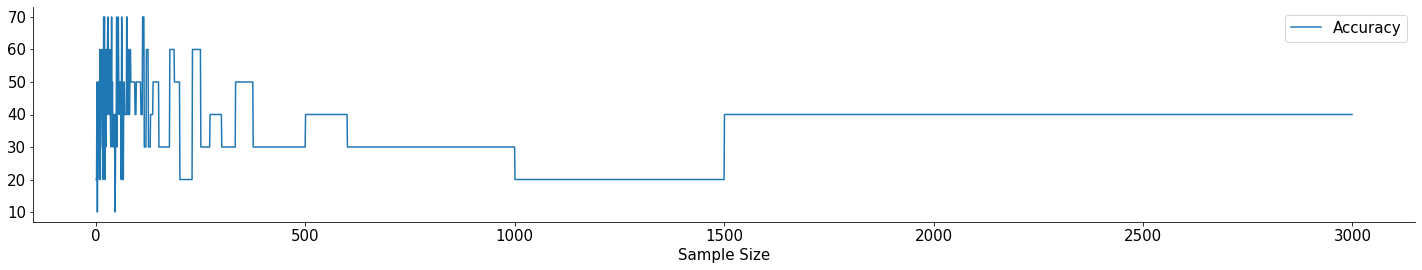

In [222]:
op_df.plot(x ='Sample Size', y='Accuracy', kind = 'line')

In [223]:
# test get_max_row
get_max_row(op_df)
# get_max_row(op_df, pick_max=False, value=60)

,Sample Size,Accuracy
0,19,70.0
0,21,70.0
0,29,70.0
0,38,70.0
0,50,70.0
0,54,70.0
0,62,70.0
0,74,70.0
0,75,70.0
0,112,70.0


Choose 115 for 70%.

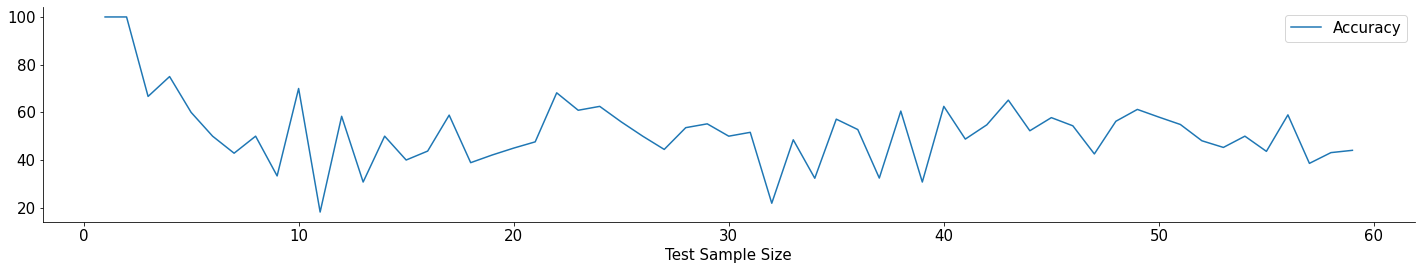

In [226]:
op_df_testdat = pd.DataFrame()
for i in range(1,len(x)):
  result = SVM_ECoG(x, y, down_samp=True, down_samp_len=115, gam=0.001, C_value=100, test_dat_size=i)
  op_sub_dat_df = pd.DataFrame({'Test Sample Size' : [i], 'Accuracy' : result[1]})
  op_df_testdat = pd.concat([op_df_testdat, op_sub_dat_df], axis=0)
get_max_row(op_df_testdat, pick_max=False, value=70)
op_df_testdat.plot(x ='Test Sample Size', y='Accuracy', kind = 'line')
# print(op_df_testdat)

In [227]:
# optimal argument values by far, with an accuracy of 76.47% for SVM for this channel (channel 44)
SVM_ECoG(x, y, down_samp=True, down_samp_len=115, gam=0.001, C_value=100, test_dat_size=22)

(0.3181818181818182, 68.18181818181817)

Now back to our main topic: see channel performance.

In [228]:
def SVM_ECoG_single_chan(alldata, sub_id, task_type, channel_id, channel_n = 46, length=60, down_samp=True, down_samp_len=115, gam=0.001, C_value=100, test_dat_size=22):
  #get data from subject 0, experiment 0
  dat = get_sub_dat(alldat, sub_id, task_type)
  datf = dat_frame_t(dat)
  dftime = dftime_win(dat)
  # get X and y input for the SVM
  X1 = slice_chan_dat(datf, dftime, channel_id)
  y = get_new_stim_id_array(dat, length=60)
  result = SVM_ECoG(X1, y)
  return result

In [232]:
SVM_ECoG_single_chan(alldat, 5, 1, 43, channel_n = 46, length=60, down_samp=True, down_samp_len=115, gam=0.001, C_value=100, test_dat_size=22)

(0.6, 40.0)

In [235]:
# run this giant!
# it worked!
# check good single channels
op_df_chan = pd.DataFrame()
for i in range(1,46):
  chan_result = SVM_ECoG_single_chan(alldat, 0, 1, i, channel_n = 46, length=60, down_samp=True, down_samp_len=115, gam=0.001, C_value=100, test_dat_size=22)
  op_sub_chan_df = pd.DataFrame({'Sub ID': [1], 'Channel' : [i], 'Accuracy' : chan_result[1]})
  op_df_chan = pd.concat([op_df_chan, op_sub_chan_df], axis=0)
# op_df_chan

In [251]:
# now we can check single channel of single participant, next we try multiple participants
op_df_chan_sub = pd.DataFrame()
for sub_id in [0, 1, 2, 3, 4, 5, 6]:
  for i in range(1,46):
    chan_result = SVM_ECoG_single_chan(alldat, sub_id, 1, i, channel_n = 46, length=60, down_samp=True, down_samp_len=157, gam=0.001, C_value=100, test_dat_size=17)
    op_sub_chan_sub_df = pd.DataFrame({'Sub ID': [sub_id], 'Channel' : [i], 'Accuracy' : chan_result[1]})
    op_df_chan_sub = pd.concat([op_df_chan_sub, op_sub_chan_sub_df], axis=0)
# op_df_chan_sub.plot(x='Channel', y='Accuracy')
op_df_chan_sub = op_df_chan_sub.pivot(index='Channel', columns='Sub ID', values='Accuracy')

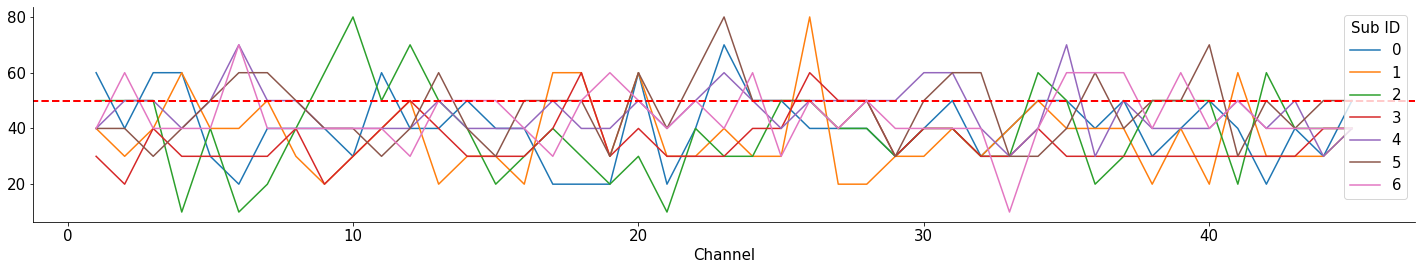

In [254]:
op_df_chan_sub_plt = op_df_chan_sub.plot()
op_df_chan_sub_plt.axhline(y=50, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)

In [ ]:
# select by creating an averaged participants?
# or create averaged accuracy?
# pause here for discussion, and move onto multiple channel selection :-)

In [ ]:
#!!!DONT RUN!!! find feature selection library, still doing
def channel_comp(dat, channel_n):
  eligible_chan_id = []
  datf = dat_frame_t(dat, channel_n = 46)
  dftime = dftime_win(dat)
  for i in range(channel_n):
    for j in range(channel_n):
      X1 = slice_chan_dat(datf, dftime, i)
      X2 = slice_chan_dat(datf, dftime, j)
      y = get_y_val(dat)
  return eligible_chan_id